In [1]:
# %matplotlib qt
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
import matplotlib
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import pandas as pd
import datetime

In [2]:
# Read serial interval
path = '../data_library/mers/SerialIntervalEstimates-2.csv'
serial_interval = pd.read_csv(path, header=None)
serial_interval = serial_interval.fillna(0)
serial_intervals = serial_interval.values.T
serial_intervals = list(serial_intervals[0])[1:]

In [3]:
# Read MERS data
path = '../data_library/mers/MERSData.csv'
data = pd.read_csv(path)

# Switch the first day data to imported
# This step was performed in the original paper
data.iloc[0, 1] = 0
data.iloc[0, 2] = 1

In [4]:
# R_t inference, same as COVID notebooks
time_key = 'Time'
num_timepoints = max(data[time_key])
data_times = data[time_key]

locally_infected_cases = data['Incidence Number']
imported_cases = data['Imported Cases']

start_times = np.arange(1, num_timepoints+1, dtype=int)
times = np.arange(num_timepoints+1)

# Same inference, but using the LocImpBranchProPosterior
tau = 27
R_t_start = tau+1
a = 1
b = 0.2

prior_dist = scipy.stats.gamma(a, scale=1/b)
median = prior_dist.median()

# Run inferences for different values of epsilon
column_names = ['Time Points', 'Mean', 'Lower bound CI', 'Upper bound CI', 'Central Probability', 'Epsilon']
sparse_epsilon_range = [0.25, 1.0, 2.0]
large_epsilon_range = np.arange(0.1, 2.5, 0.1)

inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': start_times,
        'Incidence Number': imported_cases
    }
)

all_intervals = []
all_df = pd.DataFrame(columns=column_names)
for epsilon in sparse_epsilon_range:
    inference = branchpro.LocImpBranchProPosterior(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_interval=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)
    intervals = inference.get_intervals(central_prob=.95)
    
    intervals['Epsilon'] = [epsilon] * len(intervals.index)
    all_intervals.append(intervals)
    all_df = all_df.append(intervals)
    
inference_times = sorted(list(set(intervals['Time Points'].tolist())))

proportion_time_r_more_than_1 = []
proportion_time_r_more_than_1_LowerCI = []
proportion_time_r_more_than_1_UpperCI = []
large_all_intervals = pd.DataFrame(columns=column_names)
for epsilon in large_epsilon_range:
    inference = branchpro.LocImpBranchProPosterior(
        inc_data=inc_data,
        imported_inc_data=imported_inc_data,
        epsilon=epsilon,
        daily_serial_interval=serial_intervals,
        alpha=a,
        beta=b)

    inference.run_inference(tau=tau)

    # Proportion time R > 1
    mean, lower, upper = inference.proportion_time_r_more_than_1(.95)
    proportion_time_r_more_than_1.append(mean)
    proportion_time_r_more_than_1_LowerCI.append(lower)
    proportion_time_r_more_than_1_UpperCI.append(upper)
    
    intervals = inference.get_intervals(central_prob=.95)
    intervals['Epsilon'] = [epsilon] * len(intervals.index)
    large_all_intervals = large_all_intervals.append(intervals)


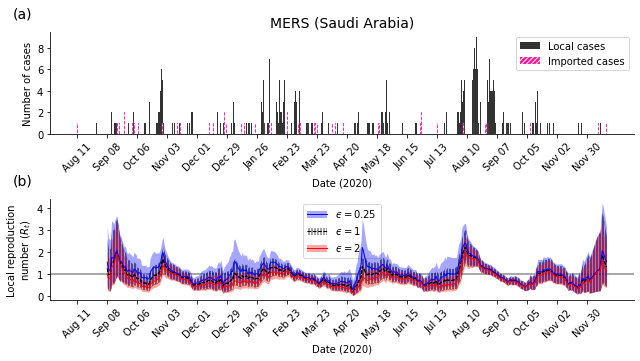

In [5]:
sparse_epsilon_range = [0.25, 1, 2]

fig = branchpro.figures.plot_regions_inference(
    datetime.datetime(2014, 8, 11),
    ['MERS (Saudi Arabia)',],
    [locally_infected_cases,],
    [imported_cases],
    datetime.datetime(2014, 8, 11) + datetime.timedelta(days=inference_times[0]-1),
    list(sparse_epsilon_range),
    [all_intervals],
    default_epsilon=1,
    show=False,
    mers=True)

fig.set_size_inches(9, 5)
axs = fig.get_axes()

axs[0].set_xticks([datetime.datetime(2014, 8, 11) + datetime.timedelta(days=int(i))
                  for i in range(len(locally_infected_cases))][::28])

axs[1].set_xticks([datetime.datetime(2014, 8, 11) + datetime.timedelta(days=int(i))
                      for i in range(len(locally_infected_cases))][::28])

plt.savefig('Figure_S5.pdf')

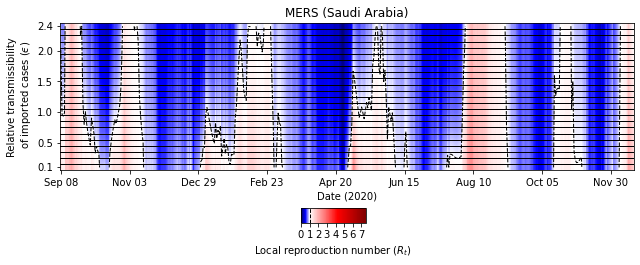

In [6]:
fig = branchpro.figures.plot_r_heatmap(
    ['MERS (Saudi Arabia)',],
    large_epsilon_range,
    [large_all_intervals,],
    datetime.datetime(2014, 8, 11) + datetime.timedelta(days=inference_times[0]-1),
    show=False,
    figsize=(9, 5),
    max_R=7.5,
    aspect=5,
    date_interval=56)

plt.savefig('Figure_S6a.pdf')

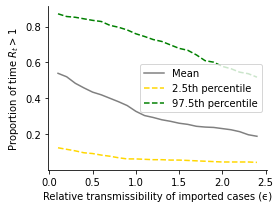

In [7]:
# Run the inference at a finer grid of epsilons
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(large_epsilon_range, proportion_time_r_more_than_1, color='gray', label='Mean')
ax.plot(large_epsilon_range, proportion_time_r_more_than_1_LowerCI, color='gold', ls='--', label='2.5th percentile')
ax.plot(large_epsilon_range, proportion_time_r_more_than_1_UpperCI, color='green', ls='--', label='97.5th percentile')
ax.set_xlabel('Relative transmissibility of imported cases (ϵ)')
ax.set_ylabel('Proportion of time ' + r'$R_t>1$')
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.set_tight_layout(True)

plt.savefig('Figure_S6b.pdf')